<a href="https://colab.research.google.com/github/Mjcherono/Week1-Module2/blob/main/Python_Programming_Logistic_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<font color="green">*To start working on this notebook, or any other notebook that we will use in the Moringa Data Science Course, we will need to save our own copy of it. We can do this by clicking File > Save a Copy in Drive. We will then be able to make edits to our own copy of this notebook.*</font>

# Python Programming: Logistic Regression

## Importing Our Libraries

In [582]:
# Importing our libraries
#
import pandas as pd
import seaborn as sb

## Example 

In [583]:
# Example 1
# ---
# You are tasked to complete the analysis of what sorts of people were likely to survive the titanic. 
# Specifically you are requested to apply logistic regression modelining 
# to predict which passengers survived the tragedy.
# ---
# Dataset url = http://bit.ly/TitanicTrainDataset
# ---
# Survived - Survival (0 = No; 1 = Yes)
# Pclass - Passenger Class (1 = 1st; 2 = 2nd; 3 = 3rd)
# Name - Name
# Sex - Sex
# Age - Age
# SibSp - Number of Siblings/Spouses Aboard
# Parch - Number of Parents/Children Aboard
# Ticket - Ticket Number
# Fare - Passenger Fare (British pound)
# Cabin - Cabin
# Embarked - Port of Embarkation (C = Cherbourg; Q = Queenstown; S = Southampton)

In [584]:
# Reading in the dataset using the Pandas
# 
titanic = pd.read_csv("http://bit.ly/TitanicTrainDataset")
titanic.columns = ['PassengerId','Survived','Pclass','Name','Sex','Age','SibSp','Parch','Ticket','Fare','Cabin','Embarked']
titanic.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


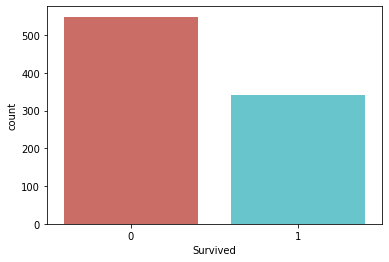

In [585]:
# Checking that our target variable is binary
# Since we are building a model to predict survival of passangers from the Titanic, 
# our target is going to be "Survived" variable from the titanic dataframe. 
# To make sure that it's a binary variable, let's use Seaborn's countplot() function.
# 
sb.countplot(x='Survived',data=titanic, palette='hls')

# from the output we see that the Survived variable is binary (0 - did not survive / 1 - survived)

In [586]:
# Checking for missing values
# 
titanic.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [587]:
# Understanding the dataset abit more
# 
titanic.info()

# Ok, so there are only 891 rows in the titanic data frame. 
# Cabin is almost all missing values, so we can drop that variable completely, 
# but what about age? Age seems like a relevant predictor for survival right? 
# We'd want to keep the variables, but it has 177 missing values.
# We are going to need to find a way to approximate for those missing values!

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [588]:
# Taking care of missing values
# So let's just go ahead and drop all the variables that aren't relevant for predicting survival. We should at least keep the following:
# ---
# Survived - This variable is obviously relevant.
# Pclass - Does a passenger's class on the boat affect their survivability?
# Sex - Could a passenger's gender impact their survival rate?
# Age - Does a person's age impact their survival rate?
# SibSp - Does the number of relatives on the boat (that are siblings or a spouse) affect a person survivability? Probability
# Parch - Does the number of relatives on the boat (that are children or parents) affect a person survivability? Probability
# Fare - Does the fare a person paid effect his survivability? Maybe - let's keep it.
# Embarked - Does a person's point of embarkation matter? It depends on how the boat was filled... Let's keep it.
# What about a person's name, ticket number, and passenger ID number? They're irrelavant for predicting survivability. 
# And as we recall, the cabin variable is almost all missing values, so we can just drop all of these.
# 
titanic_data = titanic.drop(['PassengerId','Name','Ticket','Cabin'], 1)
titanic_data.head()

# Now we have the dataframe reduced down to only relevant variables, but now we need to deal with the missing values in the age variable.

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,male,22.0,1,0,7.2500,S
1,1,1,female,38.0,1,0,71.2833,C
2,1,3,female,26.0,0,0,7.9250,S
3,1,1,female,35.0,1,0,53.1000,S
4,0,3,male,35.0,0,0,8.0500,S


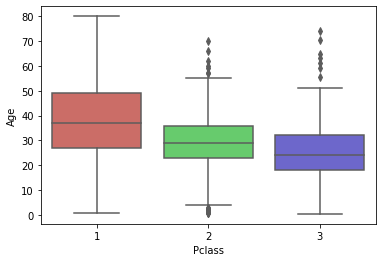

In [589]:
# Imputing missing values
# ---
# Let's look at how passenger age is related to their class as a passenger on the boat.
# 
sb.boxplot(x='Pclass', y='Age', data=titanic_data, palette='hls')

In [590]:
titanic_data.head()

# Speaking roughly, we could say that the younger a passenger is, the more likely it is for them to be in 3rd class. 
# The older a passenger is, the more likely it is for them to be in 1st class. 
# So there is a loose relationship between these variables. 
# So, let's write a function that approximates a passengers age, based on their class. 
# From the box plot, it looks like the average age of 1st class passengers 
# is about 37, 2nd class passengers is 29, and 3rd class pasengers is 24.

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,male,22.0,1,0,7.2500,S
1,1,1,female,38.0,1,0,71.2833,C
2,1,3,female,26.0,0,0,7.9250,S
3,1,1,female,35.0,1,0,53.1000,S
4,0,3,male,35.0,0,0,8.0500,S


In [591]:
# So let's write a function that finds each null value in the Age variable, and for each null, 
# checks the value of the Pclass and assigns an age value according to the average age of passengers in that class.
#
def age_approx(cols):
    Age = cols[0]
    Pclass = cols[1]
    
    if pd.isnull(Age):
        if Pclass == 1:
            return 37
        elif Pclass == 2:
            return 29
        else:
            return 24
    else:
        return Age

In [592]:
# When we apply the function and check again for null values, we see that there are no more null values in the age variable.
#
titanic_data['Age'] = titanic_data[['Age', 'Pclass']].apply(age_approx, axis=1)
titanic_data.isnull().sum()

Survived    0
Pclass      0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
Embarked    2
dtype: int64

In [593]:
# There are 2 null values in the embarked variable. We can drop those 2 records 
# without loosing too much important information from our dataset, so we will do that.
#
titanic_data.dropna(inplace=True)
titanic_data.isnull().sum()

Survived    0
Pclass      0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
Embarked    0
dtype: int64

In [594]:
titanic_data.Sex.unique()

array(['male', 'female'], dtype=object)

In [595]:
# Converting categorical variables to a dummy indicators
# ---
# The next thing we need to do is reformat our variables so that they work with the model. 
# Specifically, we need to reformat the Sex and Embarked variables into numeric variables.
#
gender = pd.get_dummies(titanic_data['Sex'],drop_first=True)
gender.head()

,male
0,1
1,0
2,0
3,0
4,1


In [596]:
titanic_data.Embarked.nunique()

3

In [597]:
embark_location = pd.get_dummies(titanic_data['Embarked'],drop_first=True)
embark_location

,Q,S
0,0,1
1,0,0
2,0,1
3,0,1
4,0,1
...,...,...
886,0,1
887,0,1
888,0,1
889,0,0


In [598]:
titanic_data.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,male,22.0,1,0,7.2500,S
1,1,1,female,38.0,1,0,71.2833,C
2,1,3,female,26.0,0,0,7.9250,S
3,1,1,female,35.0,1,0,53.1000,S
4,0,3,male,35.0,0,0,8.0500,S


In [599]:
titanic_data.drop(['Sex', 'Embarked'],axis=1,inplace=True)
titanic_data.head()

,Survived,Pclass,Age,SibSp,Parch,Fare
0,0,3,22.0,1,0,7.2500
1,1,1,38.0,1,0,71.2833
2,1,3,26.0,0,0,7.9250
3,1,1,35.0,1,0,53.1000
4,0,3,35.0,0,0,8.0500


In [600]:
titanic_dmy = pd.concat([titanic_data,gender,embark_location],axis=1)
titanic_dmy.head()

# Now we have a dataset with all the variables in the correct format!

,Survived,Pclass,Age,SibSp,Parch,Fare,male,Q,S
0,0,3,22.0,1,0,7.2500,1,0,1
1,1,1,38.0,1,0,71.2833,0,0,0
2,1,3,26.0,0,0,7.9250,0,0,1
3,1,1,35.0,1,0,53.1000,0,0,1
4,0,3,35.0,0,0,8.0500,1,0,1


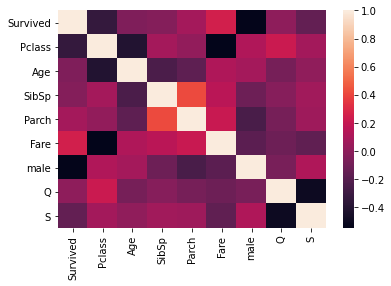

In [601]:
# Checking for independence between features¶
# 
sb.heatmap(titanic_dmy.corr())  

In [602]:
# Fare and Pclass are not independent of each other, so I am going to drop these.
# 
titanic_dmy.drop(['Fare', 'Pclass'],axis=1,inplace=True)
titanic_dmy.head()

,Survived,Age,SibSp,Parch,male,Q,S
0,0,22.0,1,0,1,0,1
1,1,38.0,1,0,0,0,0
2,1,26.0,0,0,0,0,1
3,1,35.0,1,0,0,0,1
4,0,35.0,0,0,1,0,1


In [603]:
# Checking that your dataset size is sufficient
# We have 6 predictive features that remain. The rule of thumb is 50 records per feature 
# so we need to have at least 300 records in this dataset. Let's check again.
#
titanic_dmy.info()

              
# From the output we have 889 records so we are fine.

<class 'pandas.core.frame.DataFrame'>
Int64Index: 889 entries, 0 to 890
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  889 non-null    int64  
 1   Age       889 non-null    float64
 2   SibSp     889 non-null    int64  
 3   Parch     889 non-null    int64  
 4   male      889 non-null    uint8  
 5   Q         889 non-null    uint8  
 6   S         889 non-null    uint8  
dtypes: float64(1), int64(3), uint8(3)
memory usage: 37.3 KB


In [604]:
# Splitting our dataset
#
X = titanic_dmy.drop("Survived",axis=1)
y = titanic_dmy["Survived"]

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .3, random_state=25)

In [605]:
# Fitting our model
# 
from sklearn.linear_model import LogisticRegression

LogReg = LogisticRegression()
LogReg.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [606]:
# Using our model to make a prediction
#
y_pred = LogReg.predict(X_test)

In [607]:
# Evaluating the model
#
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test, y_pred)
confusion_matrix

# The results from the confusion matrix tell us that 137 and 69 are the number of correct predictions. 
# 34 and 27 are the number of incorrect predictions.

array([[137,  27],
       [ 34,  69]])

## <font color="green">Challenge 1</font>

In [608]:
# Challenge 1
# ---
# Question: Use the Iris dataset to build a regression model to predict the type of iris flower
# ---
# Dataset url = http://bit.ly/IrisDataset
# ---
#
iris = pd.read_csv('http://bit.ly/IrisDataset')
iris.head()

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


In [609]:
iris.isnull().sum()

sepal_length    0
sepal_width     0
petal_length    0
petal_width     0
species         0
dtype: int64

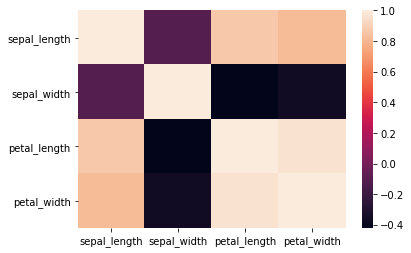

In [610]:
#Checking of independence of features
sb.heatmap(iris.corr())

In [611]:
iris.columns

Index(['sepal_length', 'sepal_width', 'petal_length', 'petal_width',
       'species'],
      dtype='object')

In [612]:
#splitting dataset
X = iris.drop('species',axis =1)
y = iris['species']

from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X, y, test_size=0.2, random_state =10)

In [613]:
#fitting model
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()
logreg.fit(X_train,y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [614]:
#predict using logistic regression
y_pred = logreg.predict(X_test)

In [615]:
#Evaluating model
from sklearn.metrics import confusion_matrix

confusion_matrix = confusion_matrix(y_pred, y_test)
confusion_matrix

array([[10,  0,  0],
       [ 0, 13,  0],
       [ 0,  0,  7]])

## <font color="green">Challenge 2</font>

In [616]:
# Challenge 2
# ---
# Question: Create a regression model that can predict whether an application will be admitted to the university or not.
# ---
# Dataset url = http://bit.ly/MarksDataset
# ---
#


## <font color="green">Challenge 3</font>

In [617]:
# Challenge 3
# ---
# Question: Predict if the client will subscribe a term deposit (variable y).
# ---
# Dataset url = http://bit.ly/BankingDataset
# ---
# 
subscription = pd.read_csv('http://bit.ly/BankingDataset')
subscription.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed,y
0,44,blue-collar,married,basic.4y,unknown,yes,no,cellular,aug,thu,210,1,999,0,nonexistent,1.4,93.444,-36.1,4.963,5228.1,0
1,53,technician,married,unknown,no,no,no,cellular,nov,fri,138,1,999,0,nonexistent,-0.1,93.200,-42.0,4.021,5195.8,0
2,28,management,single,university.degree,no,yes,no,cellular,jun,thu,339,3,6,2,success,-1.7,94.055,-39.8,0.729,4991.6,1
3,39,services,married,high.school,no,no,no,cellular,apr,fri,185,2,999,0,nonexistent,-1.8,93.075,-47.1,1.405,5099.1,0
4,55,retired,married,basic.4y,no,yes,no,cellular,aug,fri,137,1,3,1,success,-2.9,92.201,-31.4,0.869,5076.2,1


In [618]:
subscription.job.nunique()

12

In [619]:
subscription.isnull().sum()

age               0
job               0
marital           0
education         0
default           0
housing           0
loan              0
contact           0
month             0
day_of_week       0
duration          0
campaign          0
pdays             0
previous          0
poutcome          0
emp_var_rate      0
cons_price_idx    0
cons_conf_idx     0
euribor3m         0
nr_employed       0
y                 0
dtype: int64

In [620]:
#dropping irrelevant colmns
subscription.drop(['default'],axis=1,inplace=True)

subscription.head()

,age,job,marital,education,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed,y
0,44,blue-collar,married,basic.4y,yes,no,cellular,aug,thu,210,1,999,0,nonexistent,1.4,93.444,-36.1,4.963,5228.1,0
1,53,technician,married,unknown,no,no,cellular,nov,fri,138,1,999,0,nonexistent,-0.1,93.200,-42.0,4.021,5195.8,0
2,28,management,single,university.degree,yes,no,cellular,jun,thu,339,3,6,2,success,-1.7,94.055,-39.8,0.729,4991.6,1
3,39,services,married,high.school,no,no,cellular,apr,fri,185,2,999,0,nonexistent,-1.8,93.075,-47.1,1.405,5099.1,0
4,55,retired,married,basic.4y,yes,no,cellular,aug,fri,137,1,3,1,success,-2.9,92.201,-31.4,0.869,5076.2,1


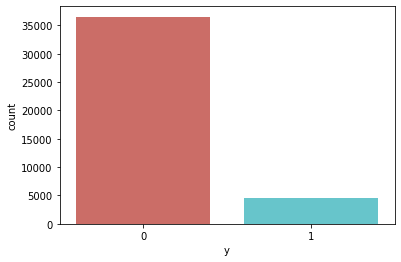

In [621]:
#checking if target variable is binary
sb.countplot(x='y',data=subscription, palette='hls')


In [622]:
subscription.dtypes

age                 int64
job                object
marital            object
education          object
housing            object
loan               object
contact            object
month              object
day_of_week        object
duration            int64
campaign            int64
pdays               int64
previous            int64
poutcome           object
emp_var_rate      float64
cons_price_idx    float64
cons_conf_idx     float64
euribor3m         float64
nr_employed       float64
y                   int64
dtype: object

In [623]:
#convertic categorical data to numerics
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
subscription.poutcome = le.fit_transform(subscription.poutcome)
subscription.day_of_week= le.fit_transform(subscription.day_of_week)
subscription.month = le.fit_transform(subscription.month)
subscription.contact = le.fit_transform(subscription.contact)
subscription.loan = le.fit_transform(subscription.loan)
subscription.housing = le.fit_transform(subscription.housing)
subscription.education = le.fit_transform(subscription.education)
subscription.marital = le.fit_transform(subscription.marital)
subscription.job = le.fit_transform(subscription.job)

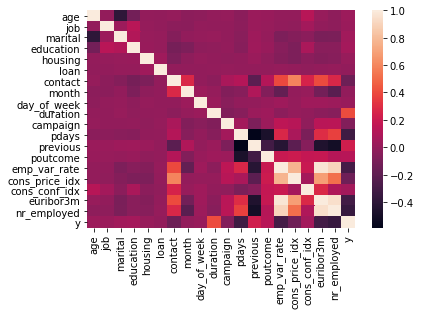

In [624]:
#checking independent features on a heatmap
sb.heatmap(subscription.corr())

In [625]:
#dropping variables that aren't independent of each other
subscription.drop(['previous','pdays'], axis=1, inplace=True)

In [626]:
#splitting the dataset for training
X = subscription.drop(['y'],axis=1)
y = subscription['y']

In [627]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train,y_test = train_test_split(X, y, test_size = 0.2, random_state =10)

In [628]:
#fit model
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression()
logreg.fit(X_train, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [629]:
y_pred = logreg.predict(X_test)

In [630]:
#evaluate model
from sklearn.metrics import confusion_matrix

confusion_matrix = confusion_matrix(y_test, y_pred)
confusion_matrix

array([[7150,  159],
       [ 635,  294]])

## <font color="green">Challenge 4</font>

In [631]:
# Challenge 4
# ---
# Question: Create a logistic regression model determine whether a user purchased a particular product.
# ---
# Dataset url = http://bit.ly/SocialNetworkAdsDataset
# ---
#


## <font color="green">Challenge 5</font>

In [632]:
# Challenge 5
# ---
# Question: Create model to determine whether a student will default on their student loans.
# ---
# Dataset url = http://bit.ly/StudentDefaultDataset
# ---
default_loan = pd.read_csv('http://bit.ly/StudentDefaultDataset')
default_loan

,default,student,balance,income
0,No,No,729.526495,44361.625074
1,No,Yes,817.180407,12106.134700
2,No,No,1073.549164,31767.138947
3,No,No,529.250605,35704.493935
4,No,No,785.655883,38463.495879
...,...,...,...,...
9995,No,No,711.555020,52992.378914
9996,No,No,757.962918,19660.721768
9997,No,No,845.411989,58636.156984
9998,No,No,1569.009053,36669.112365


In [633]:
default_loan.isnull().sum()

default    0
student    0
balance    0
income     0
dtype: int64

In [634]:
default_loan.dtypes

default     object
student     object
balance    float64
income     float64
dtype: object

In [635]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
default_loan.student= le.fit_transform(default_loan.student)

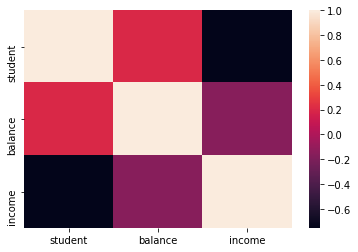

In [636]:
#Checking for independence between variables

sb.heatmap(default_loan.corr())

In [637]:
#split dataset
X = default_loan.drop(['default'], axis=1)
y = default_loan['default']

In [638]:
from sklearn.model_selection import train_test_split

X_train,X_test, y_train,y_test = train_test_split(X,y,test_size = 0.2, random_state = 20)

In [639]:
#fit model to train data
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression()
logreg.fit(X_train,y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [640]:
y_pred = logreg.predict(X_test)

In [641]:
#Evaluating model using confusion matrix
from sklearn.metrics import confusion_matrix

confusion_matrix = confusion_matrix(y_test,y_pred)
confusion_matrix

array([[1927,    8],
       [  51,   14]])